In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

# --- 1. 計算関数の定義 ---

def compute_aa_and_aia(acc_matrix: list[list[float]]) -> tuple[list[float], list[float]]:
    """AA_kとAIA_kをそれぞれ計算する。"""
    AA_list = []
    AIA_list = []
    for k in range(len(acc_matrix)):
        current_accs = acc_matrix[k][:k+1]
        AA_k = sum(current_accs) / len(current_accs)
        AA_list.append(AA_k)
        AIA_k = sum(AA_list) / len(AA_list)
        AIA_list.append(AIA_k)
    return AA_list, AIA_list

def compute_fm(acc_matrix: list[list[float]]) -> list[float]:
    """Forgetting Measure (FM_k) を計算する。"""
    num_tasks = len(acc_matrix)
    if num_tasks == 0:
        return []
        
    fm_list = [0.0]  # Task 0 終了時点では忘却は発生しないので0
    
    for k in range(1, num_tasks):
        forgetting_sum = 0.0
        for j in range(k):
            # Task j に対する過去の最高精度を計算 (l < k)
            past_accs_on_j = [acc_matrix[l][j] for l in range(j, k)]
            max_past_acc = max(past_accs_on_j)
            
            # 現在のTask jに対する精度
            current_acc = acc_matrix[k][j]
            
            # 忘却量を計算し、合計に加える
            forgetting_sum += (max_past_acc - current_acc)
            
        # Task k 終了時点での平均忘却量を計算
        avg_forgetting = forgetting_sum / k
        fm_list.append(avg_forgetting)
        
    return fm_list

def compute_im(acc_matrix: list[list[float]], joint_accs: list[float]) -> list[float]:
    """
    Intransigence Measure (IM_k) を計算する
    """
    num_tasks = len(acc_matrix)
    im_list = []

    for k in range(num_tasks):
        if k >= len(joint_accs):
            break
        a_k_star = joint_accs[k]         # 合同学習精度
        a_k_k = acc_matrix[k][k]         # 継続学習でタスクk学習直後の精度
        im_list.append(a_k_star - a_k_k) # 差を計算

    return im_list

# --- 2. 設定 ---
tasks = [
  (6,0.0),
  (6,0.1),
  (6,0.2),
  (6,0.3),
  (6,0.4),
  (6,0.5),
  (6,0.6),
  (6,0.7),
  (6,0.8),
  (6,0.9),
  (6,1.0)
]
num_tasks = len(tasks)
color_palette = {
    "CNN": "blue",
    "RNN": "green",
    "LSTM": "orange",
    "NCP": "red"
}
seeds = [1, 2, 3, 4, 5]  # 対応するシードをリストで指定
csv_baseline_base = "/work/csv/uci-har/dil-noise/none"
csv_base = "/work/csv/uci-har/dil-noise/ft"
csv_im_base = "/work/csv/uci-har/dil_noise-finetune/im/"
models_to_process = ["RNN", "CNN", "LSTM", "NCP"]

tasks = [(6, x/10) for x in range(11)]
num_tasks = len(tasks)

# --- 3. データ処理 ---

all_metrics_results = []

for model_name in models_to_process:
    print(f"\n--- Processing model: {model_name} ---")

    seed_acc_matrices = []
    seed_joint_accs = []

    for seed in seeds:
        file_path = os.path.join(csv_base, model_name.lower(), f"seed{seed}.csv")
        joint_file_path = os.path.join(csv_im_base, f"{model_name.lower()}.csv")
        baseline_path = os.path.join(csv_baseline_base, model_name.lower(), f"seed{seed}_baseline.csv")

        if not os.path.exists(file_path):
            print(f"⚠️ 警告: ファイルが見つかりません: {file_path}")
            continue
        if not os.path.exists(joint_file_path):
            print(f"⚠️ 警告: Jointファイルが見つかりません: {joint_file_path}")
            continue

        df = pd.read_csv(file_path)
        baseline_df = pd.read_csv(baseline_path)

        # baselineの最初の1行を挿入して新しいDataFrameを作る
        df = pd.concat([baseline_df.iloc[[0]], df], ignore_index=True)
        accuracies = df['テスト精度 (Test Acc)'].tolist()

        joint_df = pd.read_csv(joint_file_path)
        joint_accuracies = joint_df['テスト精度 (Test Acc)'].tolist()

        acc_matrix = []
        current_pos = 0
        for k in range(num_tasks):
            num_evals = k + 1
            if current_pos + num_evals > len(accuracies):
                print(f"❌ エラー: {model_name} seed{seed} のデータ数が不足")
                break
            row = accuracies[current_pos: current_pos + num_evals]
            acc_matrix.append(row)
            current_pos += num_evals

        if acc_matrix:
            seed_acc_matrices.append(acc_matrix)
            seed_joint_accs.append(joint_accuracies)

    if not seed_acc_matrices:
        continue

    # --- 4. seed 平均 ---
    acc_matrix_mean = []
    for k in range(num_tasks):
        max_len = max(len(seed_acc_matrices[s][k]) for s in range(len(seed_acc_matrices)))
        row_vals = []
        for j in range(max_len):
            vals = []
            for s in range(len(seed_acc_matrices)):
                if j < len(seed_acc_matrices[s][k]):
                    vals.append(seed_acc_matrices[s][k][j])
            row_vals.append(np.mean(vals))
        acc_matrix_mean.append(row_vals)

    joint_accs_mean = np.mean(seed_joint_accs, axis=0).tolist()

    # --- 5. 指標計算 ---
    aa_list, aia_list = compute_aa_and_aia(acc_matrix_mean)
    fm_list = compute_fm(acc_matrix_mean)
    im_list = compute_im(acc_matrix_mean, joint_accs_mean)

    for k in range(len(aa_list)):
        all_metrics_results.append({
            "Model": model_name,
            "Task": k,
            "Noise": tasks[k][1],
            "AA": aa_list[k],
            "AIA": aia_list[k],
            "FM": fm_list[k],
            "IM": im_list[k],
            "Task 0 Acc": acc_matrix_mean[k][0]
        })

metrics_df = pd.DataFrame(all_metrics_results)
print("\n--- ✅ Calculated Metrics (averaged over seeds) ---")
print(metrics_df)


--- Processing model: RNN ---

--- Processing model: CNN ---

--- Processing model: LSTM ---

--- Processing model: NCP ---

--- ✅ Calculated Metrics (averaged over seeds) ---
   Model  Task  Noise        AA       AIA        FM        IM  Task 0 Acc
0    RNN     0    0.0  0.903357  0.903357  0.000000 -0.002643    0.903357
1    RNN     1    0.1  0.893607  0.898482  0.012286  0.007305    0.891071
2    RNN     2    0.2  0.897548  0.898171  0.006321  0.006146    0.890571
3    RNN     3    0.3  0.888250  0.895690  0.017000  0.018756    0.881071
4    RNN     4    0.4  0.898414  0.896235  0.005500  0.002120    0.890214
5    RNN     5    0.5  0.892619  0.895633  0.012986 -0.000666    0.881500
6    RNN     6    0.6  0.883592  0.893912  0.021714  0.007884    0.869143
7    RNN     7    0.7  0.890187  0.893447  0.013296  0.007866    0.879786
8    RNN     8    0.8  0.881905  0.892164  0.022009  0.009740    0.869857
9    RNN     9    0.9  0.878786  0.890827  0.024619 -0.007099    0.850857
10   RNN 

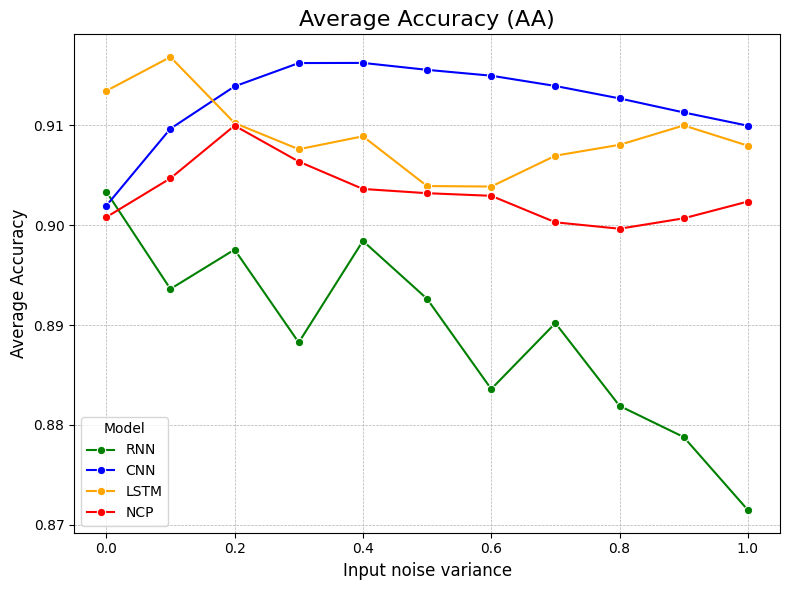

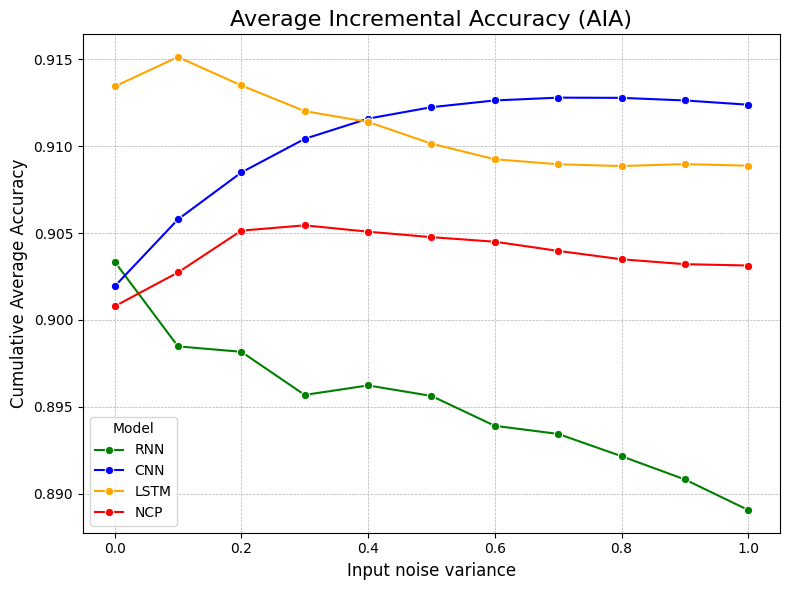

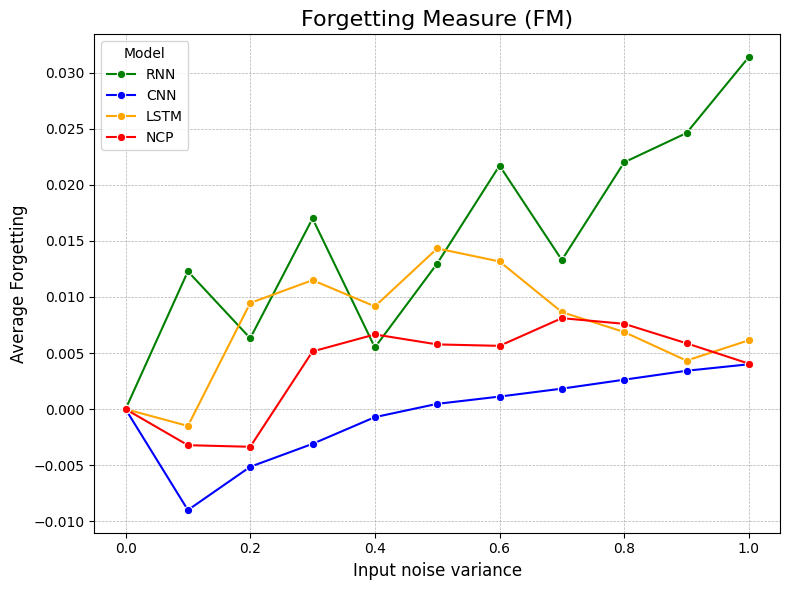

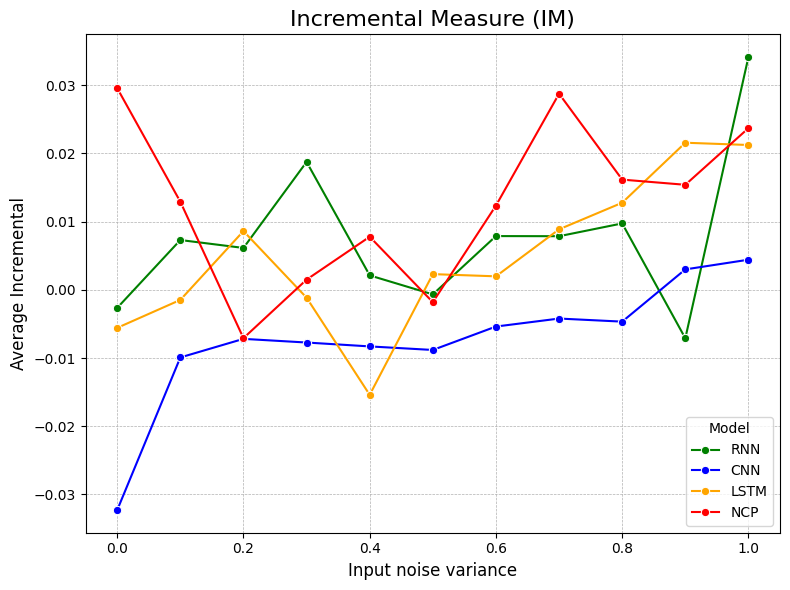

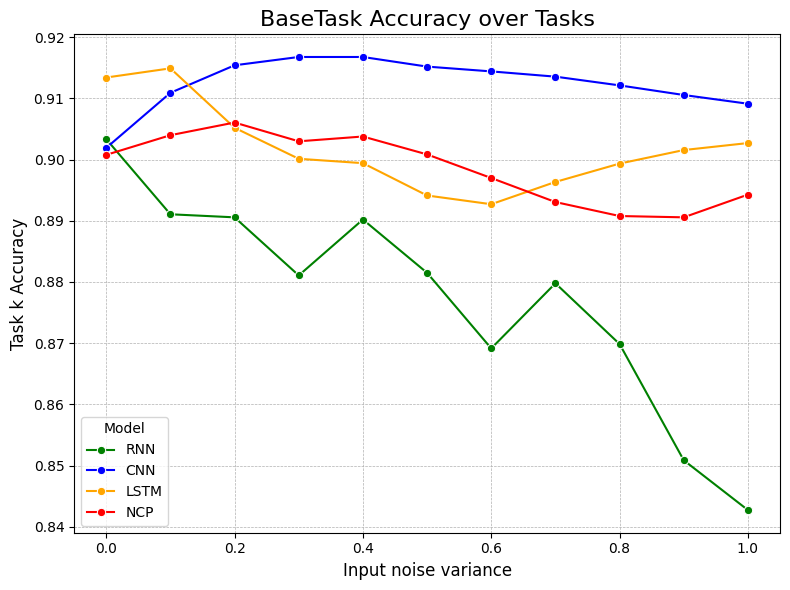

In [8]:

# --- AA ---
plt.figure(figsize=(8,6))
sns.lineplot(data=metrics_df, x="Noise", y="AA", hue="Model", palette=color_palette, marker="o")
plt.title("Average Accuracy (AA)", fontsize=16)
plt.xlabel("Input noise variance", fontsize=12)
plt.ylabel("Average Accuracy", fontsize=12)
plt.grid(True, linestyle="--", linewidth=0.5)
plt.legend(title="Model")
plt.tight_layout()
plt.show()

# --- AIA ---
plt.figure(figsize=(8,6))
sns.lineplot(data=metrics_df, x="Noise", y="AIA", hue="Model", palette=color_palette, marker="o")
plt.title("Average Incremental Accuracy (AIA)", fontsize=16)
plt.xlabel("Input noise variance", fontsize=12)
plt.ylabel("Cumulative Average Accuracy", fontsize=12)
plt.grid(True, linestyle="--", linewidth=0.5)
plt.legend(title="Model")
plt.tight_layout()
plt.show()

# --- FM ---
plt.figure(figsize=(8,6))
sns.lineplot(data=metrics_df, x="Noise", y="FM", hue="Model", palette=color_palette, marker="o")
plt.title("Forgetting Measure (FM)", fontsize=16)
plt.xlabel("Input noise variance", fontsize=12)
plt.ylabel("Average Forgetting", fontsize=12)
plt.grid(True, linestyle="--", linewidth=0.5)
plt.legend(title="Model")
plt.tight_layout()
plt.show()

# --- IM ---
plt.figure(figsize=(8,6))
sns.lineplot(data=metrics_df, x="Noise", y="IM", hue="Model", palette=color_palette, marker="o")
plt.title("Incremental Measure (IM)", fontsize=16)
plt.xlabel("Input noise variance", fontsize=12)
plt.ylabel("Average Incremental", fontsize=12)
plt.grid(True, linestyle="--", linewidth=0.5)
plt.legend(title="Model")
plt.tight_layout()
plt.show()


# --- Task 0 Acc ---
plt.figure(figsize=(8,6))
sns.lineplot(data=metrics_df, x="Noise", y="Task 0 Acc", hue="Model", palette=color_palette, marker="o")
plt.title("BaseTask Accuracy over Tasks", fontsize=16)
plt.xlabel("Input noise variance", fontsize=12)
plt.ylabel("Task k Accuracy", fontsize=12)
plt.grid(True, linestyle="--", linewidth=0.5)
plt.legend(title="Model")
plt.tight_layout()
plt.show()